# LIBS

In [1]:
# scikit-learn import
from sklearn.model_selection import train_test_split

# scipy.stats imports
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, shapiro

# custom imports
from constants import ALPHA, DAYS, RANDOM_STATE
from functions import convert_date

# standard Python imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# READ FILE

Comprehensive Geriatric Assessment (CGA) is a multidimensional and systematic evaluation of older adults, aiming to understand their medical, functional, psychological, and social aspects. The variables utilized in this analysis draw inspiration from the research papers: [Predictors of Functional Decline Among Older Adults With Cancer: A Registry-Based Retrospective Cohort Study](https://cancer.jmir.org/2019/2/e12163/) and [Development and temporal validation of a practical prognostic scoring system (ONCOGERIATRIC INDEX -OGI) based on the comprehensive geriatric assessment to predict early death in elderly cancer patients: A 892 patients cohort study](https://ascopubs.org/doi/10.1200/JCO.2018.36.15_suppl.10049). Baseline Laboratory Tests (BLT) play a crucial role in the comprehensive evaluation of elderly oncologic patients, aligning with the multidimensional approach of the CGA: [Baseline laboratory tests as predictors of early death risk in 746 elderly oncologic patients: A prospective cohort study](https://ascopubs.org/doi/abs/10.1200/JCO.2019.37.15_suppl.e23039).

## - Dataframe

In [2]:
# Define the file path for the data file
file_path = '../dataset/dataset.xlsx'

# Specify data types (dtype) for each column
dtypes = {
    'CHARLSON': float,
    'KARNOFSKY': float,
    'MAN-Escore-TR': int,
    'Death': str,
    'Diagnosis': str,
    'Age': int,
    'Gender': 'category',
    'Hemoglobin': float,
    'Leukocyte': float,
    'Platelet': float,
    'Creatinine': float,
    'Primary Site': 'category'
}

# Read the Excel file and select only the desired columns with specified data types
df = pd.read_excel(
    file_path, 
    usecols=dtypes.keys(),
    dtype=dtypes
)

# VISUALIZE

## - Describe

In [3]:
df.describe()

,CHARLSON,KARNOFSKY,MAN-Escore-TR,Age,Hemoglobin,Leukocyte,Platelet,Creatinine
count,2730.000000,2731.000000,2748.000000,2748.000000,2747.000000,2720.000000,2743.000000,2742.000000
mean,2.289744,79.838887,10.768559,75.080786,12.076374,7411.315074,265701.895735,1.263530
std,2.825563,17.483945,3.022113,7.445471,2.095752,3403.300605,111395.984444,4.400504
min,0.000000,10.000000,0.000000,60.000000,3.000000,1360.000000,11000.000000,0.100000
25%,0.000000,70.000000,9.000000,69.000000,10.800000,5300.000000,194000.000000,0.740000
50%,1.000000,80.000000,12.000000,74.000000,12.300000,6700.000000,243000.000000,0.870000
75%,4.000000,90.000000,13.000000,80.000000,13.500000,8600.000000,308000.000000,1.040000
max,13.000000,100.000000,14.000000,103.000000,19.800000,49100.000000,956000.000000,87.000000


## - Head

In [4]:
df.head()

,CHARLSON,KARNOFSKY,MAN-Escore-TR,Death,Diagnosis,Age,Gender,Hemoglobin,Leukocyte,Platelet,Creatinine,Primary Site
0,0.0,90.0,9,26aug2016,2015-01-15 00:00:00,76,2,12.3,9300.0,263000.0,0.64,4
1,0.0,80.0,6,25mar2015,2015-01-15 00:00:00,69,2,9.4,13600.0,462000.0,0.74,2
2,8.0,70.0,5,09sep2015,2015-01-19 00:00:00,83,2,11.2,3500.0,165000.0,0.57,2
3,4.0,100.0,12,13dec2016,2015-01-19 00:00:00,70,2,13.2,4200.0,220000.0,9.35,4
4,0.0,80.0,12,NaN,2015-01-19 00:00:00,75,2,10.7,6400.0,343000.0,0.74,3


## - Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   CHARLSON       2730 non-null   float64 
 1   KARNOFSKY      2731 non-null   float64 
 2   MAN-Escore-TR  2748 non-null   int64   
 3   Death          1001 non-null   object  
 4   Diagnosis      2748 non-null   object  
 5   Age            2748 non-null   int64   
 6   Gender         2748 non-null   category
 7   Hemoglobin     2747 non-null   float64 
 8   Leukocyte      2720 non-null   float64 
 9   Platelet       2743 non-null   float64 
 10  Creatinine     2742 non-null   float64 
 11  Primary Site   2748 non-null   category
dtypes: category(2), float64(6), int64(2), object(2)
memory usage: 220.7+ KB


# FILTER

- Idade

In [6]:
# The dataset was filtered to include only individuals over the age of 60
df = df[df.Age >= 60]

# Display the resulting count after filtering
print("Number of records after filtering:", len(df))

Number of records after filtering: 2748


# PREPROCESS

Convert the 'Preenchimento' and 'DataSaida' columns to dates with error handling, calculate the difference in days, and remove the original date columns


In [7]:
# Convert 'Diagnosis' and 'Death' columns to datetime, handling errors by setting them as NaN
df['Diagnosis'] = pd.to_datetime(df['Diagnosis'], errors='coerce')
df['Death'] = pd.to_datetime(df['Death'].apply(convert_date), errors='coerce') 

# Calculate the difference in days between 'Death' (Death Date) and 'Diagnosis' (Diagnosis Date)
df['DiagnosisToDeathDays'] = df['Death'] - df['Diagnosis']
df['DiagnosisToDeathDays'] = df['DiagnosisToDeathDays'].dt.days

# Remove the "Diagnosis" and "DataSaida" columns from the DataFrame
df = df.drop(columns=['Diagnosis', 'Death'], axis=1)

Primary Site Categorization

In [8]:
# Create a 'Death (DAYS days)' column in the DataFrame
df[f'Death ({DAYS} days)'] = df['DiagnosisToDeathDays'] <= DAYS

# Remove the DiagnosisToDeathDays column from the DataFrame
df = df.drop(columns='DiagnosisToDeathDays', axis=1)

# Group the data by "Primary Site Categorization" and calculate the sum of fatal cases and the total number of cases in each category.
mortality_df = df.groupby('Primary Site')[f'Death ({DAYS} days)'].agg(['sum', 'count']).reset_index()

# Rename the columns to make the result clearer.
mortality_df.columns = ['Primary Site Categorization', 'Fatal Cases', 'Total Cases']

# Calculate the mortality rate (proportion of fatal cases) in each category.
mortality_df['Mortality Rate'] = (mortality_df['Fatal Cases'] / mortality_df['Total Cases']) * 100

# Sort the DataFrame by the 'Mortality Rate' column in descending order.
mortality_df = mortality_df.sort_values(by='Mortality Rate', ascending=False)

# Display the sorted DataFrame.
print(mortality_df)

  Primary Site Categorization  Fatal Cases  Total Cases  Mortality Rate
5                           6           81          168       48.214286
6                           7           44          133       33.082707
1                           2          203          705       28.794326
4                           5           23          147       15.646259
3                           4           39          287       13.588850
0                           1           46          852        5.399061
2                           3           24          456        5.263158


In [9]:
# Create a mapping based on the ascending order of lethality.
mapping = {category: rank for rank, category in enumerate(mortality_df['Primary Site Categorization'], start=1)}

# Apply the mapping to the 'Primary Site Categorization' column.
df['Primary Site'] = df['Primary Site'].map(mapping)

# VARIABLES

## - Input

Features, also called input variables, are the data used by a ML model to make predictions or classifications regarding the target (output variable)."

In [11]:
X = df.drop(columns=[f'Death ({DAYS} days)'],axis=1) 

Outliers are values that are far from the other values in a dataset. They can be either very high or very low values in relation to the overall distribution of the data. Outliers can be caused by measurement errors, data entry errors, or they may be true extreme values that represent rare or extreme events in the real world. The presence of outliers can affect statistical analysis and lead to misleading conclusions if not treated correctly.

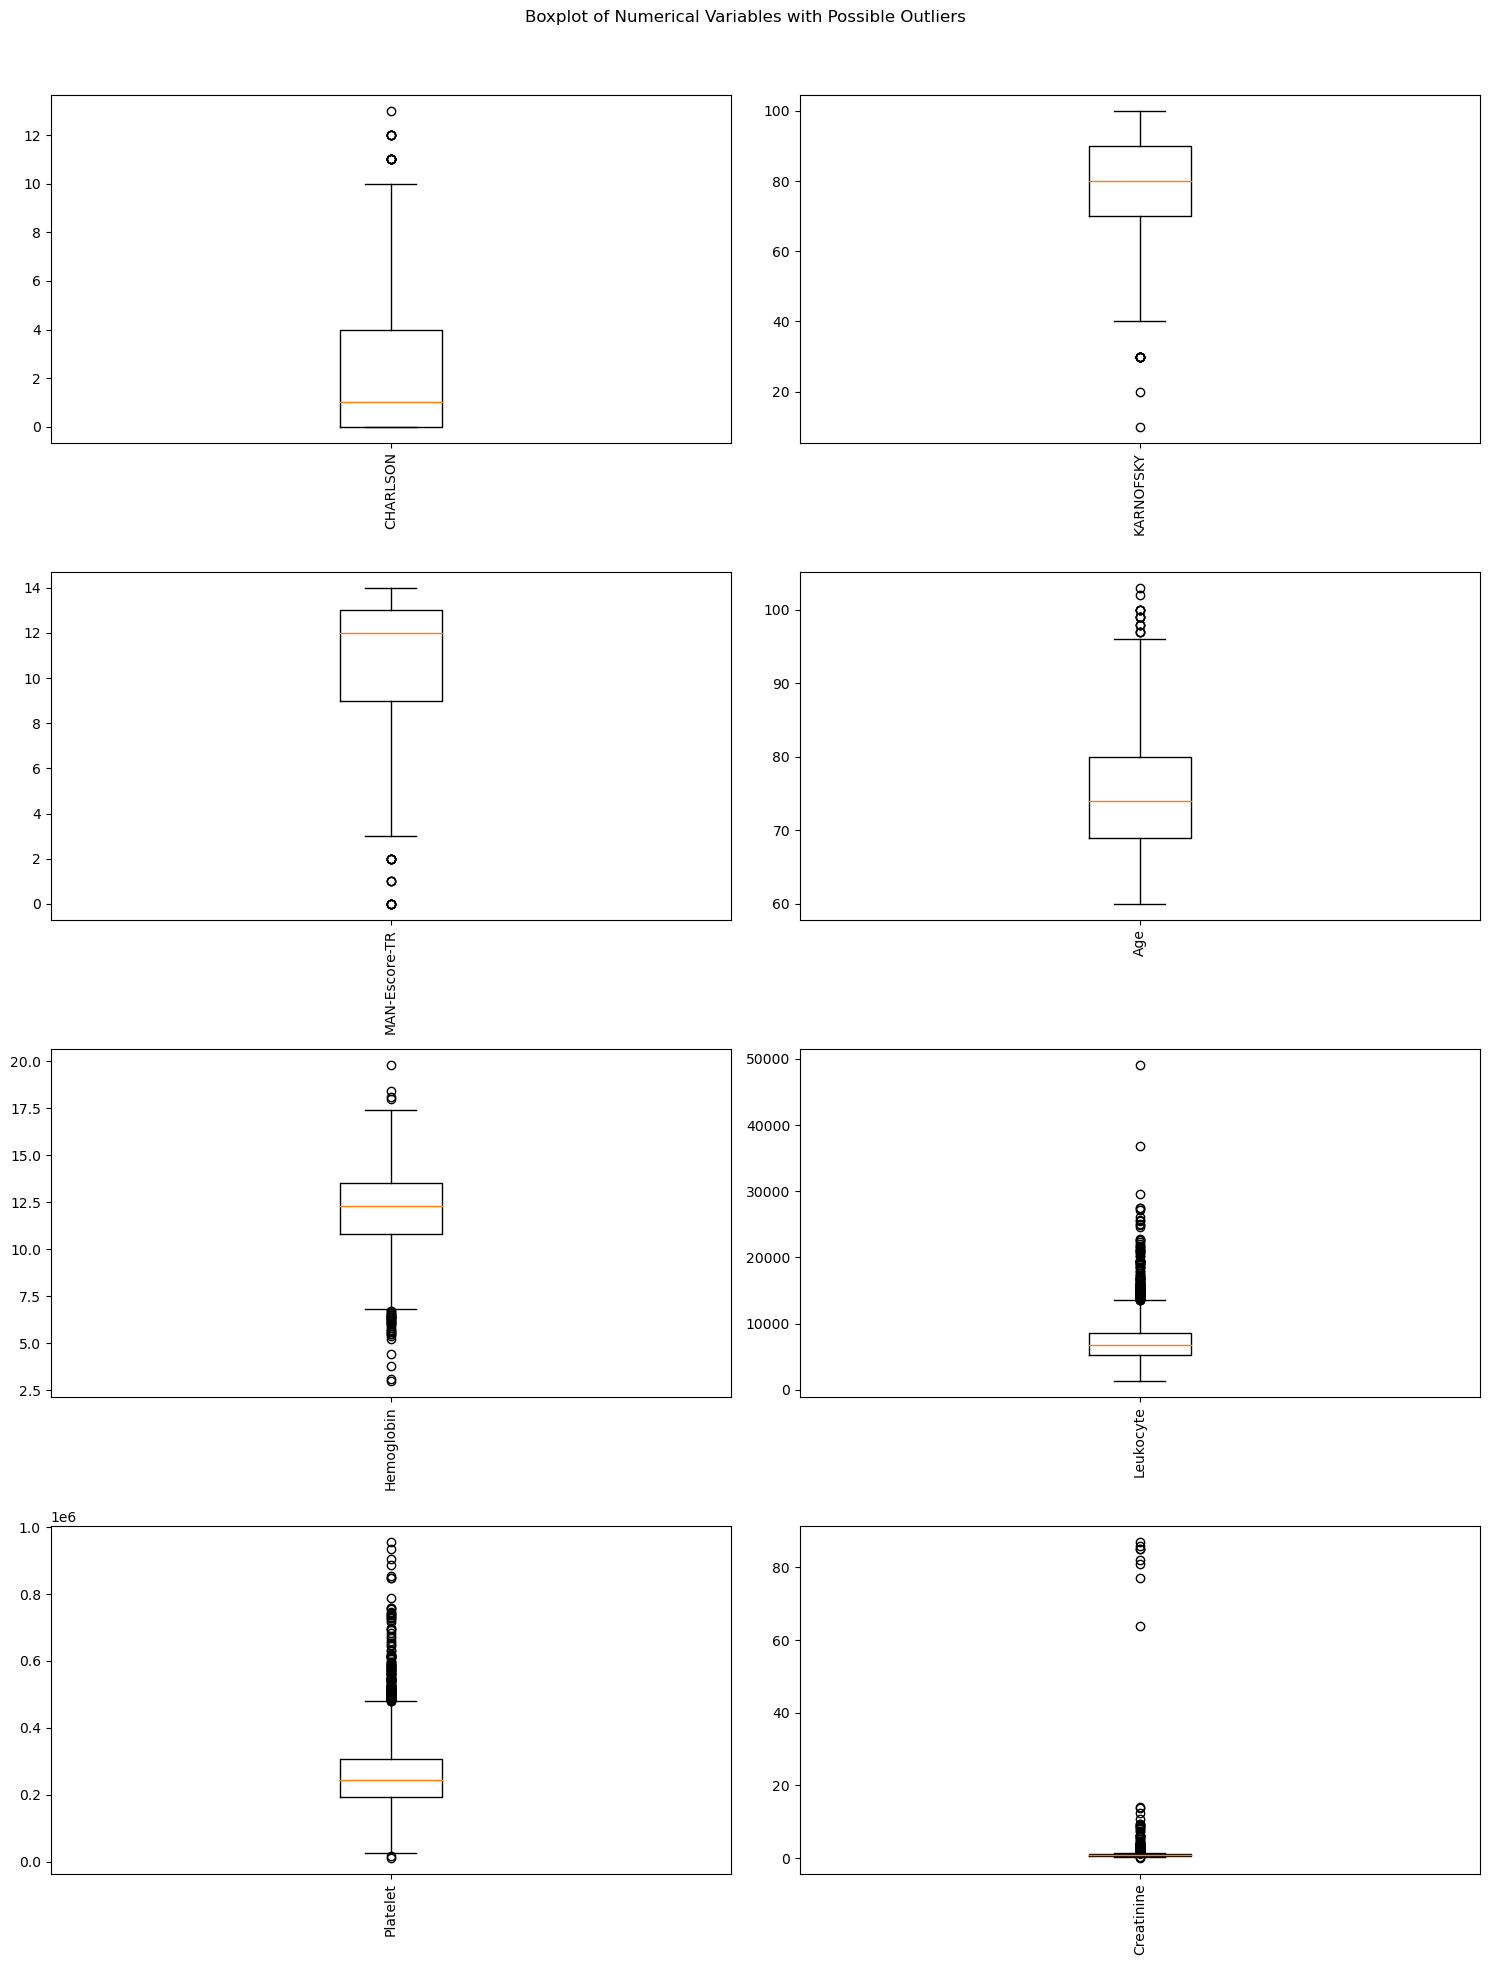

In [12]:
# Filter the DataFrame to select only numeric columns
numeric_columns = X.select_dtypes(include=['number'])

# Find the values that have outliers in the numeric columns
q1 = numeric_columns.quantile(0.25)
q3 = numeric_columns.quantile(0.75)
iqr = q3 - q1
outliers = ((numeric_columns < (q1 - 1.5 * iqr)) | (numeric_columns > (q3 + 1.5 * iqr)))

# Create a new DataFrame with only the columns that have outliers
X_outliers = numeric_columns.loc[:, outliers.any() & (numeric_columns.nunique() > 2)]

# Calculate the number of rows and columns for subplots
num_vars_per_row = 2
num_cols = min(len(X_outliers.columns), num_vars_per_row)
num_rows = int(np.ceil(len(X_outliers.columns) / num_cols))

# Increase the figure height
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))

# Flatten the axes for easier iteration
axs = axs.flatten()

for i, col in enumerate(X_outliers.columns):
    if i < len(axs):
        axs[i].boxplot(X_outliers[col].dropna())
        axs[i].set_xticklabels([col], rotation='vertical')  # Set names on the bottom and vertical

# Remove empty subplots
for i in range(len(X_outliers.columns), len(axs)):
    axs[i].remove()

# Set the general title for the plot
fig.suptitle('Boxplot of Numerical Variables with Possible Outliers')

# Adjust the spacing between the subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rectangle to fit the suptitle
plt.show()

In [13]:
df['Creatinine'] = np.where(df['Creatinine'] > 3, None, df['Creatinine'])
df['Leukocyte'] = np.where(df['Leukocyte'] > 30000, None, df['Leukocyte'])
df['Platelet'] = np.where(df['Platelet'].between(10000, 700000, inclusive='both'), None, df['Platelet'])

## - Output

The target is the ML model's output variable, representing the outcome it seeks to predict or classify using the input variables, or features.

In [14]:
y = df[f'Death ({DAYS} days)'] 

The code below generates a visualization that demonstrates the distribution of different exit conditions.

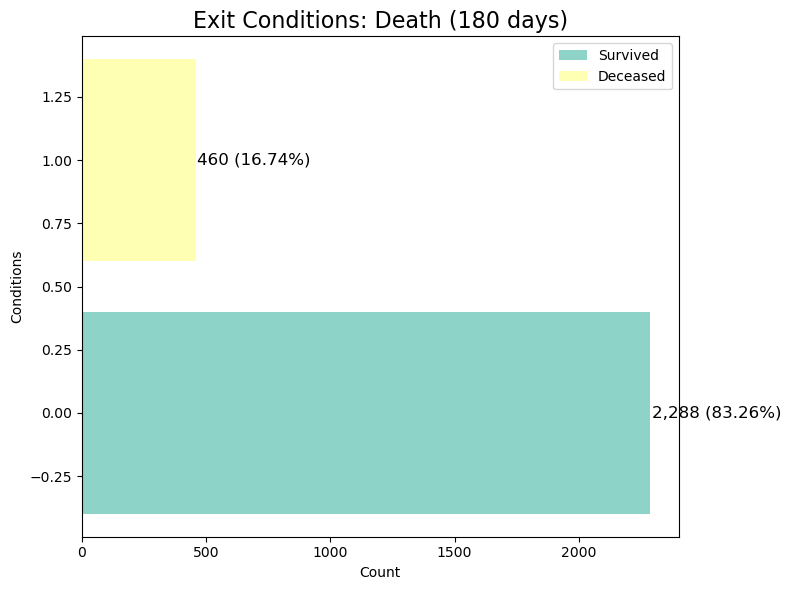

In [15]:
# Get unique value counts
counts = y.value_counts()

# Calculate percentages
percentages = (counts / counts.sum()) * 100

# Create a figure with a custom size and white background
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')

# Create horizontal bar chart
colors = plt.cm.Set3.colors  # You can choose a different colormap
bars = ax.barh(counts.index, counts.values, color=colors)

# Add data labels to the bars
for index, (value, percentage) in enumerate(zip(counts.values, percentages)):
    ax.text(value + 5, index, f"{value:,d} ({percentage:.2f}%)", va='center', fontsize=12)

# Add title and adjust layout
plt.title(f"Exit Conditions: Death ({DAYS} days)", fontsize=16)
plt.xlabel("Count")
plt.ylabel("Conditions")

# Create legend
legend_labels = ['Survived', 'Deceased']
plt.legend(bars, legend_labels)

plt.tight_layout()

# Display chart
plt.show()

# DATA DIVISION

The importance of dividing data into training and testing subsets lies in the ability to assess a machine learning model's performance on unseen data. By using a portion of the available data for training, we can build a model that learns the underlying patterns in the data. Then, by evaluating the model's performance on a separate set of testing data, we can obtain an estimate of its ability to generalize to new, unseen data.

In [16]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

# FEATURE SELECTION

In [17]:
FEATURES = []

## - Statistical

In this analysis, we will be performing feature selection based on statistical differences. 

In [18]:
def analysis_categorical_feature(feature):
    
    # Merge the data into a single DataFrame
    data = pd.concat([X_train, y_train], axis=1)
    
    # Filter the data to remove rows with missing values in the feature of interest.
    data = data.dropna(subset=feature)
        
    # Create contingency table
    contingency_table = pd.crosstab(data[feature], data[f'Death ({DAYS} days)'])
    
    # Calculate percentages
    percentages = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

    # Plot the contingency table
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap="YlGnBu")
    plt.xlabel(f'Death ({DAYS} days)')
    plt.ylabel(feature)
    plt.title('Contingency Table')
    plt.show()

    # Print counts and percentages
    for index, row in contingency_table.iterrows():
        total_samples = row.sum()
        positive_percentage = 100 * row[True] / total_samples
        negative_percentage = 100 * row[False] / total_samples
        
        print(f"{feature} == {index}: {total_samples} ({100*total_samples/len(X_train):.2f}%)")
        print(f" - positives: {row[True]} ({positive_percentage:.2f}%)")
        print(f" - negatives: {row[False]} ({negative_percentage:.2f}%)")
    
    # Perform the Chi-square test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
    print("\nChi-square test:")
    print("Chi-square statistic:", chi2_stat)
    print("p-value:", p_value, '\n')
    
    return p_value

In [19]:
def analysis_numerical_feature(feature, test='auto'):
    
    # Merge the data into a single DataFrame
    data = pd.concat([X_train, y_train], axis=1)
    
    # Filter the data to remove rows with missing values in the feature of interest.
    data = data.dropna(subset=feature)
        
    # Descriptive statistics for the entire feature
    print(data[feature].describe())
    
    # Descriptive statistics
    print(data.groupby(f'Death ({DAYS} days)')[feature].describe())

    # Density plot
    data.groupby(f'Death ({DAYS} days)')[feature].plot(kind='density',legend=True)
    plt.show()
        
    # grouping
    group0 = data[data[f'Death ({DAYS} days)'] == 0][feature]
    group1 = data[data[f'Death ({DAYS} days)'] == 1][feature]
    
    # Check normality
    if test == 'auto':
        _, p_value_group0 = shapiro(group0)
        _, p_value_group1 = shapiro(group1)

        if p_value_group0 > 0.05 and p_value_group1 > 0.05:
            test = 't-test'
        else:
            test = 'U test'
    
    # Mann-Whitney U test
    if test == 'U test':
        U_stat, p_value = mannwhitneyu(group0, group1)
        print("Mann-Whitney U test:")
        print("U statistic:", U_stat)
        print("p-value:", p_value, '\n')
        return p_value
      
    # Student's t-test
    elif test == 't-test':  
        t_stat, p_value = ttest_ind(group0, group1)
        print("Student's t-test:")
        print("t-statistic:", t_stat)
        print("p-value:", p_value, '\n')
        return p_value

----------------------------- CHARLSON -----------------------------
count    2189.000000
mean        2.293741
std         2.810444
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        13.000000
Name: CHARLSON, dtype: float64
                   count      mean       std  min  25%  50%  75%   max
Death (180 days)                                                      
False             1826.0  2.013691  2.598066  0.0  0.0  1.0  3.0  13.0
True               363.0  3.702479  3.365353  0.0  0.0  2.0  7.0  12.0


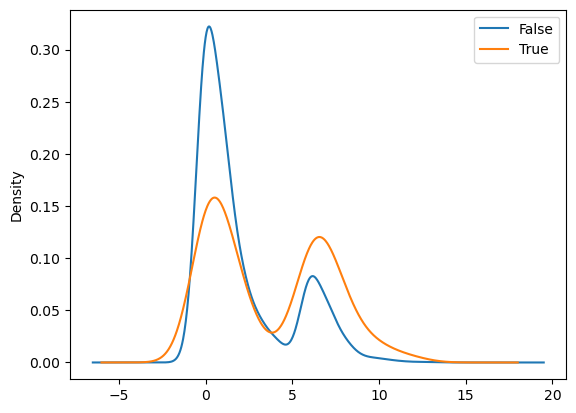

Mann-Whitney U test:
U statistic: 239733.0
p-value: 6.1089466699987234e-18 

----------------------------- KARNOFSKY -----------------------------
count    2188.000000
mean       79.670932
std        17.326619
min        10.000000
25%        70.000000
50%        80.000000
75%        90.000000
max       100.000000
Name: KARNOFSKY, dtype: float64
                   count      mean        std   min   25%   50%   75%    max
Death (180 days)                                                            
False             1825.0  82.69589  15.569176  10.0  70.0  90.0  90.0  100.0
True               363.0  64.46281  17.728013  20.0  50.0  70.0  80.0  100.0


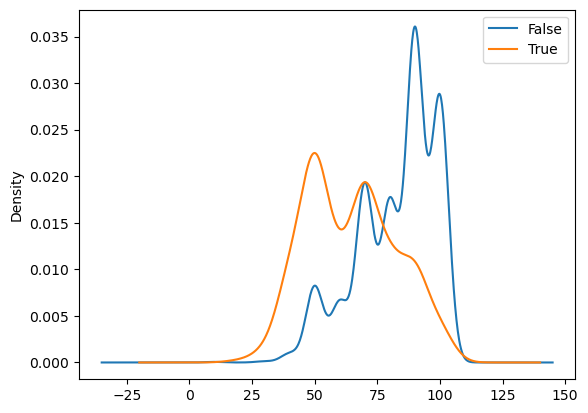

Mann-Whitney U test:
U statistic: 512948.5
p-value: 7.301401646072305e-64 

--------------------------- MAN-ESCORE-TR ---------------------------
count    2198.000000
mean       10.737034
std         3.032971
min         0.000000
25%         9.000000
50%        12.000000
75%        13.000000
max        14.000000
Name: MAN-Escore-TR, dtype: float64
                   count       mean       std  min   25%   50%   75%   max
Death (180 days)                                                          
False             1830.0  11.260656  2.727928  0.0  9.25  12.0  14.0  14.0
True               368.0   8.133152  3.133051  0.0  6.00   8.0  10.0  14.0


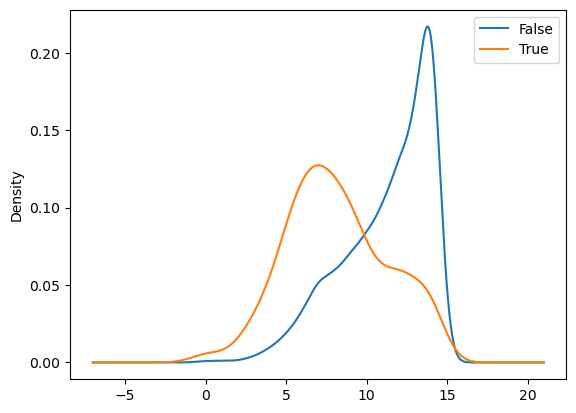

Mann-Whitney U test:
U statistic: 519927.5
p-value: 2.139493093151105e-62 

-------------------------------- AGE --------------------------------
count    2198.000000
mean       75.120564
std         7.437283
min        60.000000
25%        69.000000
50%        74.000000
75%        80.000000
max       103.000000
Name: Age, dtype: float64
                   count       mean       std   min   25%   50%   75%    max
Death (180 days)                                                            
False             1830.0  75.033333  7.337783  60.0  69.0  74.0  80.0  103.0
True               368.0  75.554348  7.909728  61.0  69.0  75.0  81.0   98.0


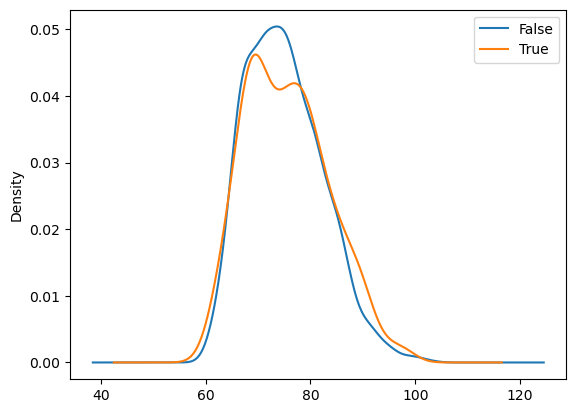

Mann-Whitney U test:
U statistic: 325709.5
p-value: 0.3212256895303989 

------------------------------ GENDER ------------------------------


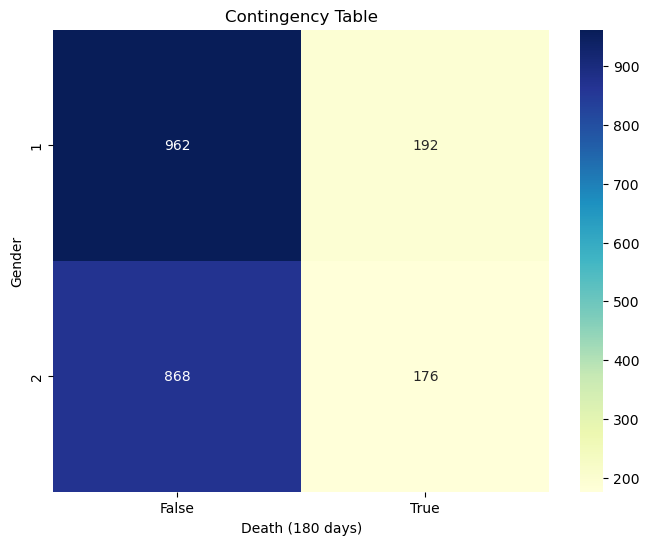

Gender == 1: 1154 (52.50%)
 - positives: 192 (16.64%)
 - negatives: 962 (83.36%)
Gender == 2: 1044 (47.50%)
 - positives: 176 (16.86%)
 - negatives: 868 (83.14%)

Chi-square test:
Chi-square statistic: 0.006567494191187497
p-value: 0.935410079921655 

---------------------------- HEMOGLOBIN ----------------------------
count    2197.000000
mean       12.080519
std         2.093537
min         3.000000
25%        10.800000
50%        12.300000
75%        13.500000
max        19.800000
Name: Hemoglobin, dtype: float64
                   count       mean       std  min   25%    50%   75%   max
Death (180 days)                                                           
False             1829.0  12.340405  1.905948  5.4  11.1  12.50  13.7  18.4
True               368.0  10.788859  2.474328  3.0   9.1  10.75  12.5  19.8


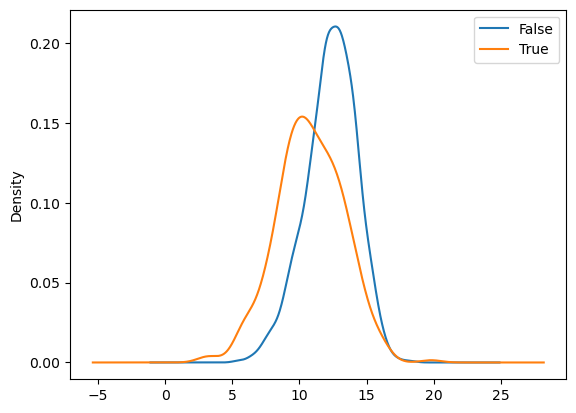

Mann-Whitney U test:
U statistic: 466494.5
p-value: 1.1899947479636154e-31 

----------------------------- LEUKOCYTE -----------------------------
count     2171.000000
mean      7403.128973
std       3357.592772
min       1360.000000
25%       5300.000000
50%       6700.000000
75%       8600.000000
max      49100.000000
Name: Leukocyte, dtype: float64
                   count         mean          std     min     25%     50%  \
Death (180 days)                                                             
False             1807.0  6942.680133  2698.883953  1360.0  5100.0  6470.0   
True               364.0  9688.928571  4985.797824  1900.0  6307.5  8500.0   

                      75%      max  
Death (180 days)                    
False              8005.0  27100.0  
True              11325.0  49100.0  


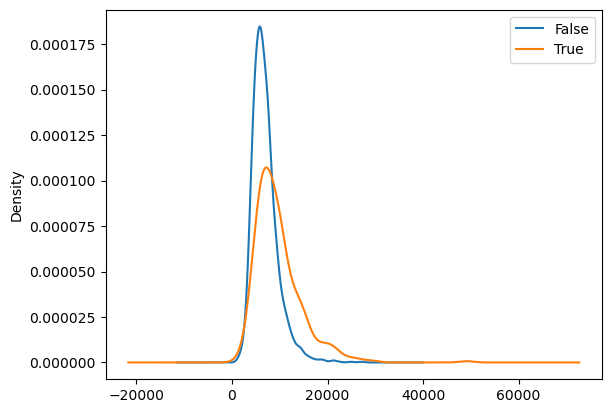

Mann-Whitney U test:
U statistic: 201331.5
p-value: 1.4322928828575975e-31 

----------------------------- PLATELET -----------------------------
count      2194.000000
mean     264559.708295
std      107597.227240
min       11000.000000
25%      194000.000000
50%      242000.000000
75%      307750.000000
max      934000.000000
Name: Platelet, dtype: float64
                   count           mean            std      min       25%  \
Death (180 days)                                                            
False             1827.0  254657.909141   94779.641975  25000.0  192000.0   
True               367.0  313852.861035  147052.647114  11000.0  210500.0   

                       50%       75%       max  
Death (180 days)                                
False             238000.0  295000.0  847000.0  
True              291000.0  403000.0  934000.0  


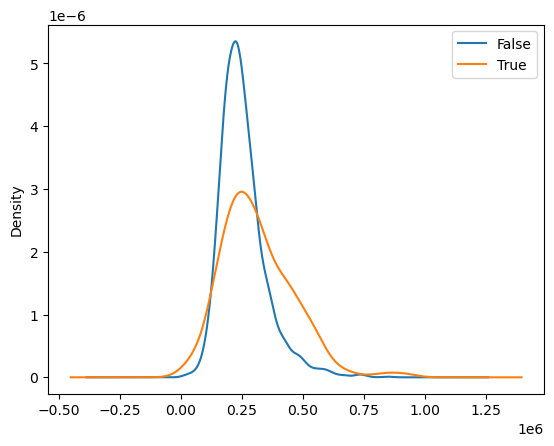

Mann-Whitney U test:
U statistic: 251181.5
p-value: 3.161574450397864e-14 

---------------------------- CREATININE ----------------------------
count    2193.000000
mean        1.283730
std         4.552658
min         0.100000
25%         0.740000
50%         0.870000
75%         1.050000
max        86.000000
Name: Creatinine, dtype: float64
                   count      mean       std   min   25%   50%     75%   max
Death (180 days)                                                            
False             1827.0  1.281160  4.647300  0.10  0.75  0.87  1.0300  86.0
True               366.0  1.296557  4.053068  0.37  0.68  0.85  1.1475  77.0


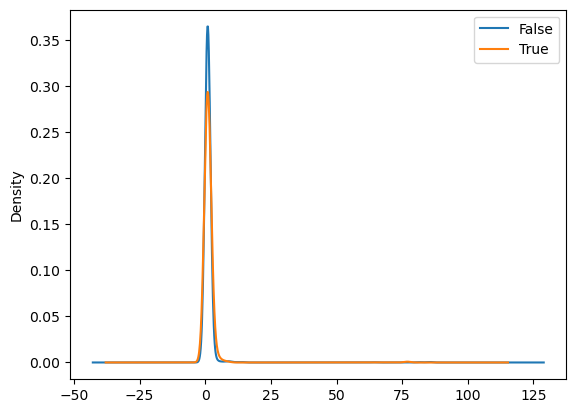

Mann-Whitney U test:
U statistic: 355069.5
p-value: 0.06070762729111939 

--------------------------- PRIMARY SITE ---------------------------


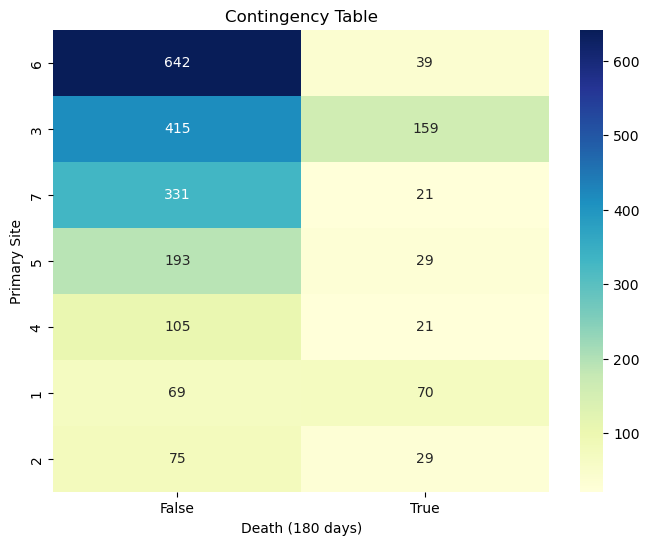

Primary Site == 6: 681 (30.98%)
 - positives: 39 (5.73%)
 - negatives: 642 (94.27%)
Primary Site == 3: 574 (26.11%)
 - positives: 159 (27.70%)
 - negatives: 415 (72.30%)
Primary Site == 7: 352 (16.01%)
 - positives: 21 (5.97%)
 - negatives: 331 (94.03%)
Primary Site == 5: 222 (10.10%)
 - positives: 29 (13.06%)
 - negatives: 193 (86.94%)
Primary Site == 4: 126 (5.73%)
 - positives: 21 (16.67%)
 - negatives: 105 (83.33%)
Primary Site == 1: 139 (6.32%)
 - positives: 70 (50.36%)
 - negatives: 69 (49.64%)
Primary Site == 2: 104 (4.73%)
 - positives: 29 (27.88%)
 - negatives: 75 (72.12%)

Chi-square test:
Chi-square statistic: 262.16459576826054
p-value: 1.028881795644397e-53 



In [20]:
for feature in X_train.columns:
    print('-'*(33-len(feature)//2), feature.upper(), '-'*(33-len(feature)//2))
       
    if X_train[feature].dtype.name in ['int64', 'float64']:
        p = analysis_numerical_feature(feature)
    else:
        p = analysis_categorical_feature(feature)
    
    if p < ALPHA:
        FEATURES.append(feature)

## - Correlation

Highly correlated features can provide redundant information and may not add much value to the model. In such cases, it is possible to consider removing one of the features to avoid multicollinearity and reduce the complexity of the model.

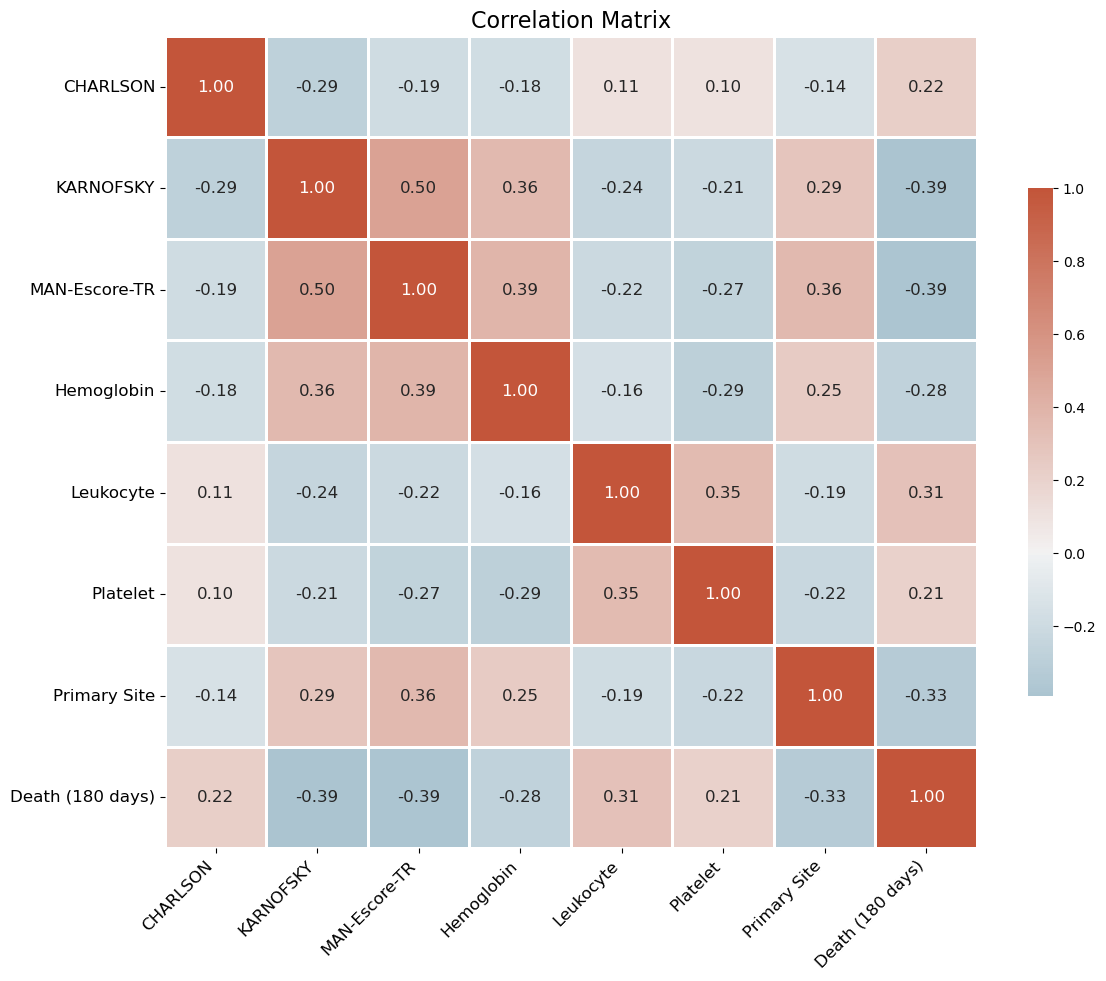

In [21]:
# Concatenate features and target variable
data = pd.concat([X_train[FEATURES], y_train], axis=1)

# Compute the correlation matrix
corr = data.corr()

# Set up the matplotlib figure with a larger size
plt.figure(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0, annot=True, fmt='.2f', square=True,
            linewidths=1, cbar_kws={"shrink": 0.6}, annot_kws={"fontsize": 12})

# Customize tick labels for better readability
plt.xticks(rotation=45, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)

# Add a title
plt.title("Correlation Matrix", fontsize=16)

# Automatically adjust the layout to avoid clipping the labels
plt.tight_layout()

plt.show()

# SAVE

In [22]:
X_train[FEATURES].to_csv('../dataset/X_train.csv')
X_test[FEATURES].to_csv('../dataset/X_test.csv')
y_train.to_csv('../dataset/y_train.csv')
y_test.to_csv('../dataset/y_test.csv')